In [1]:
### This notebook contains the code that will load the pre-trained weights for the age detector model available in the deep face package
#### Author: Hugo Albuquerque Cosme da Silva
#### Creation date: 2023-12-24

# Imports

In [16]:
import os
import gdown
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random
from deepface.basemodels import VGGFace
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Convolution2D, Flatten, Activation
import cv2


In [17]:
def loadModel(
    url="https://github.com/serengil/deepface_models/releases/download/v1.0/age_model_weights.h5",
) -> Model:

    model = VGGFace.baseModel()

    # --------------------------

    classes = 101
    base_model_output = Sequential()
    base_model_output = Convolution2D(classes, (1, 1), name="predictions")(model.layers[-4].output)
    base_model_output = Flatten()(base_model_output)
    base_model_output = Activation("softmax")(base_model_output)

    # --------------------------

    age_model = Model(inputs=model.input, outputs=base_model_output)

    # --------------------------

    # load weights
    output = "/home/hualcosa/Documents/iu_project_edge_ai/project_files/artifacts/model_weights/age_model_weights.h5"
    if os.path.isfile(output) != True:
        gdown.download(url, output, quiet=False)

    age_model.load_weights(output)

    return age_model
    

# Loading the model

In [18]:
model = loadModel()

Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/age_model_weights.h5
To: /home/hualcosa/Documents/iu_project_edge_ai/project_files/artifacts/model_weights/age_model_weights.h5
100%|██████████| 539M/539M [00:40<00:00, 13.4MB/s] 


In [19]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d_13_input (I  [(None, 224, 224, 3)]     0         
 nputLayer)                                                      
                                                                 
 zero_padding2d_13 (ZeroPad  (None, 226, 226, 3)       0         
 ding2D)                                                         
                                                                 
 conv2d_16 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 zero_padding2d_14 (ZeroPad  (None, 226, 226, 64)      0         
 ding2D)                                                         
                                                                 
 conv2d_17 (Conv2D)          (None, 224, 224, 64)      36928     
                                                           

# testing the model

I have downloaded the UTKFace dataset from kaggle and now I will try to see if the model is making reasonable predicions.<br>
link to download the dataset: https://www.kaggle.com/datasets/jangedoo/utkface-new

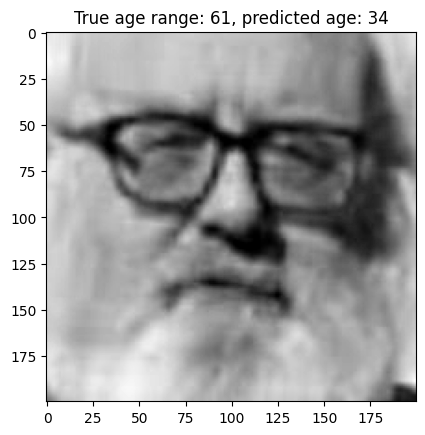

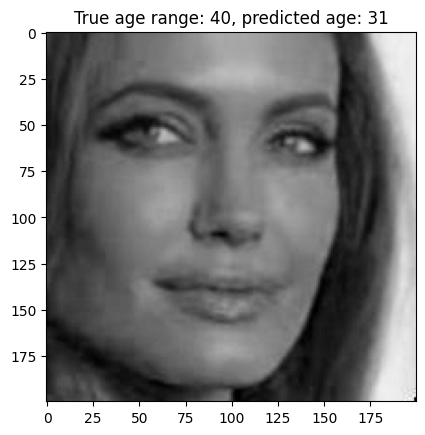

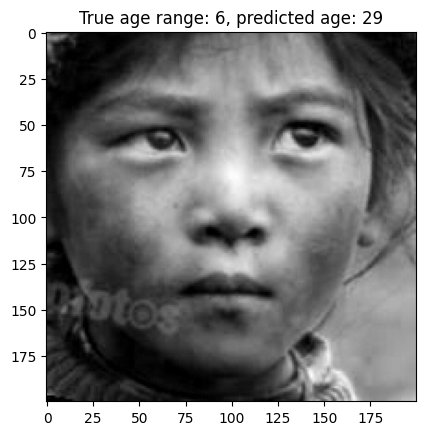

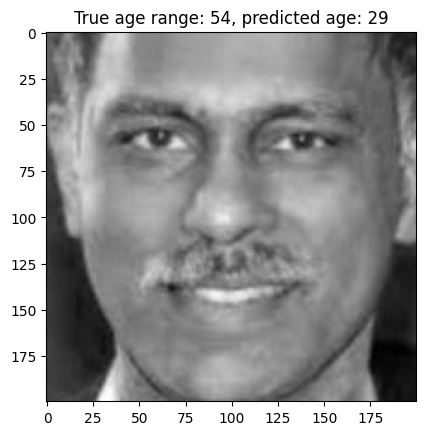

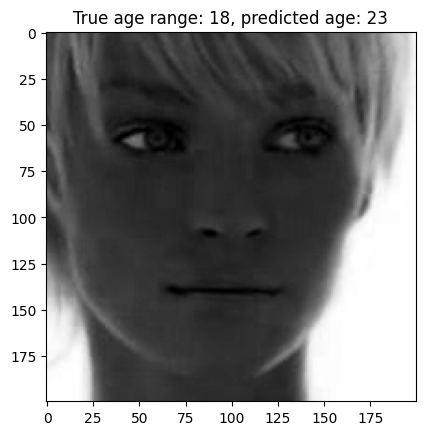

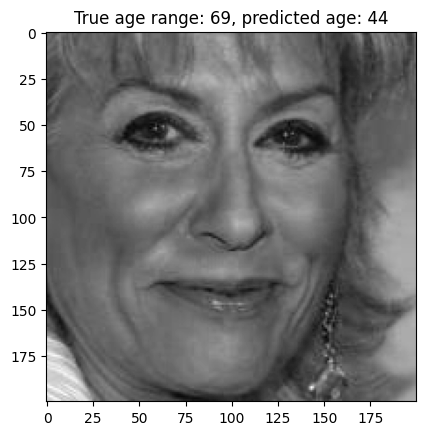

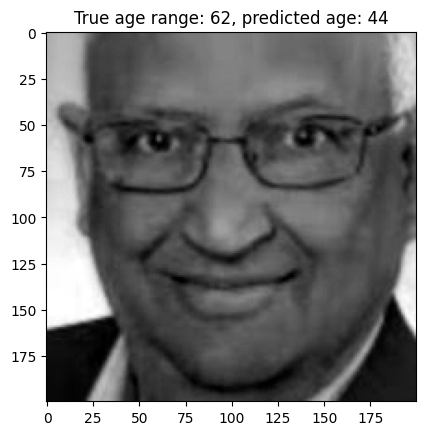

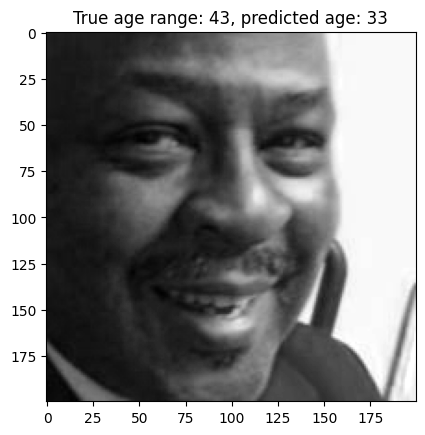

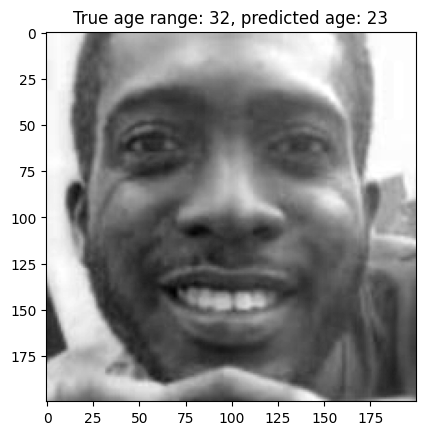

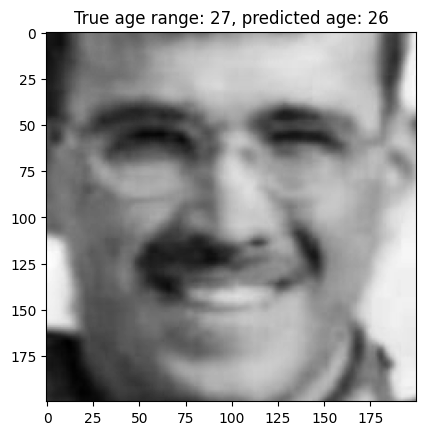

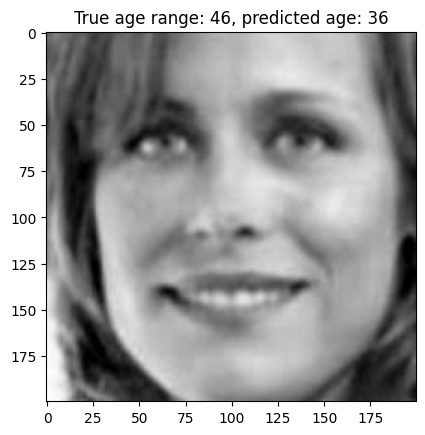

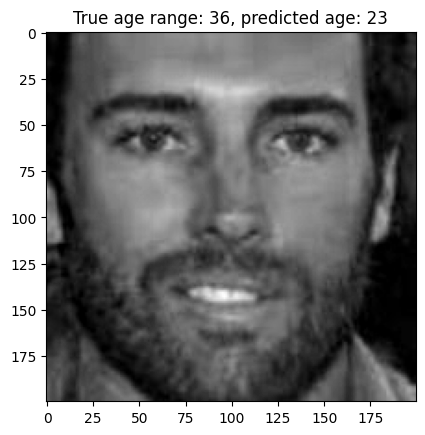

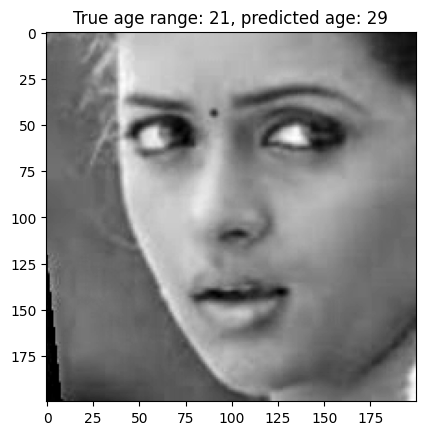

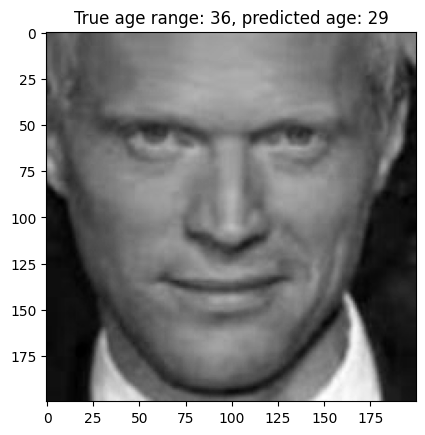

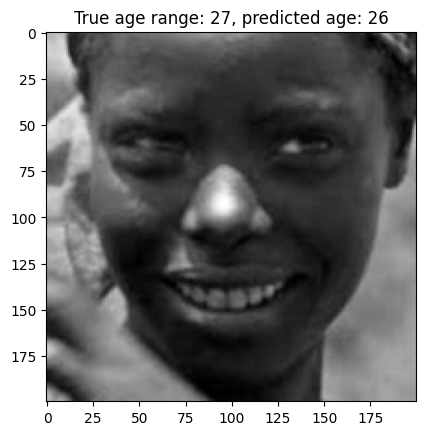

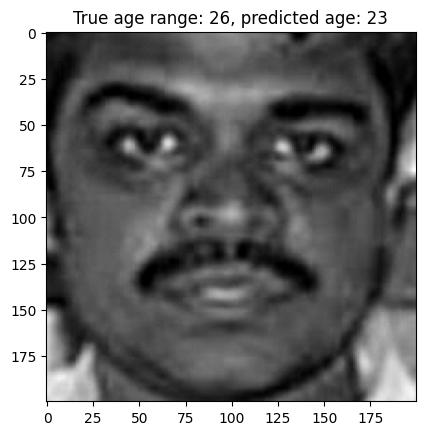

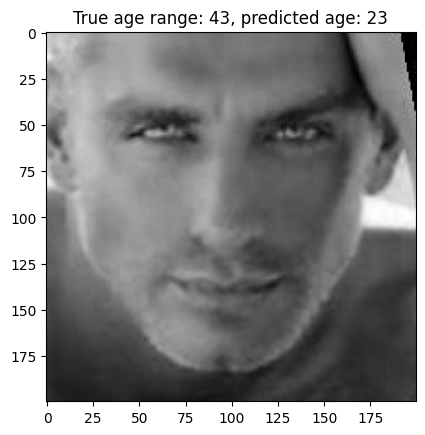

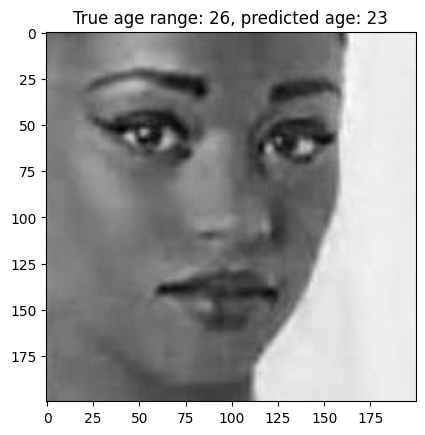

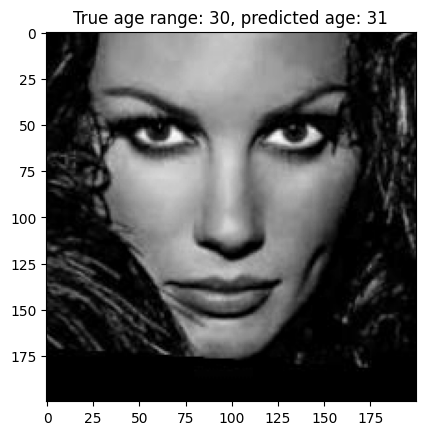

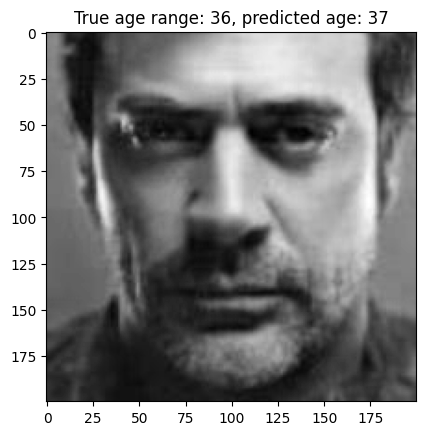

In [21]:
# testing the model on 20 random images
path = "/home/hualcosa/Documents/iu_project_edge_ai/project_files/UTKFace"

for _ in range(20):
    img = random.choice(os.listdir(path))
    ages = img.split("_")[0]
    img = cv2.imread(os.path.join(path, img))

    img_copy = img.copy()
    # resizing image
    img = cv2.resize(img, (224, 224))
    # scaling image
    img = img / 255
    # adding batch dimension
    img = np.expand_dims(img, axis=0)
    # performing inference
    pred_age = np.argmax(model.predict(img, verbose=0))

    # taking a glimpse at predicted age vs true age
    plt.imshow(img_copy[:,:,0], cmap='gray')
    plt.title(f"True age range: {ages}, predicted age: {pred_age}")
    plt.show()

# Saving model

In [15]:
tf.saved_model.save(model, export_dir="/home/hualcosa/Documents/iu_project_edge_ai/project_files/artifacts/models/age")

INFO:tensorflow:Assets written to: /home/hualcosa/Documents/iu_project_edge_ai/project_files/artifacts/models/age/assets


INFO:tensorflow:Assets written to: /home/hualcosa/Documents/iu_project_edge_ai/project_files/artifacts/models/age/assets


# Evaluating the performance in the evaluation images
In this section I will evaluate the performance of the saved model(BEFORE CONVERTION TO TF-LITE format) on a test-set of 20 images. These images that will also be used to evaluate the perfomance of the deployed models in the Android application

In [22]:
img_paths = '/home/hualcosa/Documents/iu_project_edge_ai/evaluation_images'
img_paths = [os.path.join(img_paths, i) for i in os.listdir(img_paths)]

In [30]:
# This list is going to store the comparison between true age class vs predicted age class.
# I am using the reference that age 65 is the threshold separating young from elderly people
evals = []
for path in img_paths:
    # retrieving the original names from the file names:
    age_label, gender_label, emotion_label, _ = path.split('/')[-1].split("_")
    # read image
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_orig = img.copy() 
    # the model expects data in float32 format
    img = img.astype('float32')
    img_gender_age = cv2.resize(img, (224,224))
    img_gender_age = img_gender_age.reshape(1, 224, 224, 3) / 255 # normalizing the img

    predicted_age = "young" if model.predict(img_gender_age, verbose=0).argmax() < 65 else "elderly"
    evals.append(int(age_label == predicted_age))

In [32]:
print(f"The original model accuracy is: {100 * sum(evals)/ len(evals)} %")

The original model accuracy is: 66.66666666666667 %
